# Modeling - ethereum - v2

# Setup

## Library import
We import all the required Python libraries

In [206]:
import os

# Data manipulation
from feature_engine.encoding import RareLabelEncoder, CountFrequencyEncoder
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import (
    LGBMClassifier, plot_importance, create_tree_digraph, plot_tree
)
import missingno as msno
from pycaret.classification import ClassificationExperiment
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_selection import RFECV
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV, cross_validate,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import set_config

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

# Options for pandas
set_config(transform_output = "pandas")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.5f}'.format)
# pd.options.display.float_format = '{:.5f}'.format
# pd.options.display.max_rows = 120

sns.set_context(context='paper', font_scale=2, rc=None)
sns.set_style("ticks")
sns.set_palette(sns.color_palette())

## Local library import
We import all the required local libraries libraries

In [2]:
os.chdir('../')
from src.utils.data_describe import breve_descricao, serie_nulos, cardinalidade, check_for_equal_columns
os.chdir('./notebooks/')

def round_4(x):
    return x.round(4)

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [76]:
RAW_FOLDER = '../data/raw/'
INTERIM_FOLDER = '../data/interim/'
PROCESSED_FOLDER = '../data/processed/'
REPORTS_FOLDER = '../reports/'
RANDOM_STATE = 42

train_size = 0.15

# palette = sns.color_palette("Spectral", as_cmap=True)
palette = sns.color_palette("husl", 10)
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8616090647292522, 0.536495730113334, 0.19548899031476086),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.46810256823426105, 0.6699492535792404, 0.1928958739904499),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 (0.433280341176423, 0.6065273407962815, 0.9585467098271748),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 (0.962272393509669, 0.3976451968965351, 0.8008274363432775)]

# Experience 01 - Only numerical attributes

## Data import

In [4]:
df_train_exp_01 = pd.read_parquet(INTERIM_FOLDER + 'df_train_exp_01.pqt')
df_test_exp_01 = pd.read_parquet(INTERIM_FOLDER + 'df_test_exp_01.pqt')

display(df_train_exp_01.head(3))

,Address,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,total_transactions_(including_tnx_to_create_contract),total_Ether_sent,total_ether_received,total_ether_balance,Total_ERC20_tnxs,ERC20_total_Ether_received,ERC20_total_ether_sent,ERC20_total_Ether_sent_contract,ERC20_uniq_sent_addr,ERC20_uniq_rec_addr,ERC20_uniq_rec_contract_addr,ERC20_avg_time_between_contract_tnx,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name
0,0x0020731604c882cf7bf8c444be97d17b19ea4316,1,1457.31000,34.12000,4815.43000,3,13,0,10,3,1.00000,2.50105,1.34844,1.00087,11.27787,5.84292,16,17.52875,17.52978,0.00104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0x002bf459dc58584d58886169ea0e80f3ca95ffaf,1,3976.50000,834.77000,9622.53000,2,2,0,1,2,0.58627,0.94751,0.76689,0.58541,0.94728,0.76635,4,1.53269,1.53378,0.00109,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.33700,1.33700,1.33700,0.00000,0.00000,0.00000,0.00000,1.00000
2,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,1,112.90000,31.87000,321.42000,2,3,0,3,1,0.00102,0.81780,0.43961,0.50039,0.81751,0.65895,5,1.31790,1.31882,0.00092,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.33700,1.33700,1.33700,0.00000,0.00000,0.00000,0.00000,1.00000


# Light Gradient Boosting - Categorical features encoded by frequency

## Data import

In [5]:
df_raw = pd.read_parquet(INTERIM_FOLDER + 'ethereum_complete.pqt')

df_train_exp_02 = pd.read_parquet(INTERIM_FOLDER + 'df_cleaned_train_exp_02_transformed.pqt')
df_test_exp_02 = pd.read_parquet(INTERIM_FOLDER + 'df_cleaned_test_exp_02_transformed.pqt')

X_train_exp_02 = df_train_exp_02.drop(columns=['FLAG'])
y_train_exp_02 = df_train_exp_02[['FLAG']]

X_test_exp_02 = df_test_exp_02.drop(columns=['FLAG'])
y_test_exp_02 = df_test_exp_02[['FLAG']]

display(X_train_exp_02.head(3))

,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,total_transactions_(including_tnx_to_create_contract),total_Ether_sent,total_ether_received,total_ether_balance,Total_ERC20_tnxs,ERC20_total_Ether_received,ERC20_total_ether_sent,ERC20_total_Ether_sent_contract,ERC20_uniq_sent_addr,ERC20_uniq_rec_addr,ERC20_uniq_rec_contract_addr,ERC20_avg_time_between_contract_tnx,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name,ERC20_most_sent_token_type,ERC20_most_rec_token_type
3691,67691.12000,0.00000,135382.23000,2,1,0,1,2,0.70927,0.70927,0.70927,0.10700,0.29554,0.20127,3,0.40254,0.70927,0.30673,7.00000,139.77633,0.00000,0.00000,0.00000,5.00000,7.00000,0.00000,0.00000,77.37208,19.96805,0.00000,0.00000,0.00000,0.00000,7.00000,0.89006,0.31874
152,23488.73000,33.36000,48178.53000,2,36,0,26,2,0.01038,9.99000,1.33005,0.07579,48.30435,24.19007,38,48.38014,47.88187,-0.49828,2.00000,1.33700,0.00000,0.00000,0.00000,2.00000,2.00000,0.00000,0.00000,1.33700,0.66850,0.00000,0.00000,0.00000,0.00000,2.00000,0.89006,0.16704
1175,0.00000,0.00000,0.00000,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.33700,0.86644,0.00000,0.00000,0.00000,0.00000,1.00000,0.89006,0.51421


## Random search

In [268]:
# Search space for the random search step 

max_depth = np.arange(3, 36, 5).tolist()
num_leaves = np.arange(2**min(max_depth), 70, 5).tolist()

dct_params = dict(
#     boosting_type = ['gbdt', 'dart', 'rf'],
    max_depth = max_depth,
    num_leaves = num_leaves,
    learning_rate = [0.0001, 0.001, 0.01, 0.1],
    n_estimators = np.arange(50, 600, 100).tolist(),
)

dct_params

{'max_depth': [3, 8, 13, 18, 23, 28, 33],
 'num_leaves': [8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1],
 'n_estimators': [50, 150, 250, 350, 450, 550]}

In [269]:
classifier_lgbm = LGBMClassifier(
    random_state=RANDOM_STATE, n_jobs=-1, silent='warn', objective='binary', importance_type='gain',
)

rscv = RandomizedSearchCV(
    classifier_lgbm, dct_params, error_score='raise', random_state=RANDOM_STATE, n_iter=100,
    return_train_score=True, scoring='roc_auc', cv=10, 
)

search = rscv.fit(X_train_exp_02, y_train_exp_02)

best_rscv = search.best_params_
best_rscv

{'num_leaves': 28, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.1}

In [270]:
df_random_search_results = pd.DataFrame.from_dict(rscv.cv_results_, orient='columns')[
    ['rank_test_score', 'param_num_leaves', 'param_n_estimators', 'param_max_depth', 'param_learning_rate',
     'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'mean_test_score', 'std_test_score',
     'mean_train_score', 'std_train_score']
]

df_random_search_results.sort_values(by=['rank_test_score'], ascending=True)[:10]

,rank_test_score,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,mean_train_score,std_train_score
38,1,28,250,3,0.10000,0.08845,0.01507,0.00772,0.00192,0.99885,0.00083,1.00000,0.00000
9,2,53,450,23,0.10000,0.41878,0.05154,0.00857,0.00161,0.99884,0.00064,1.00000,0.00000
33,3,18,250,23,0.10000,0.19720,0.01591,0.00706,0.00099,0.99879,0.00080,1.00000,0.00000
91,4,13,450,33,0.10000,0.25200,0.01369,0.00792,0.00063,0.99877,0.00082,1.00000,0.00000
73,5,28,250,23,0.10000,0.22371,0.00753,0.00762,0.00067,0.99876,0.00062,1.00000,0.00000
52,6,48,550,8,0.10000,0.39607,0.02265,0.00881,0.00119,0.99876,0.00073,1.00000,0.00000
92,7,23,250,18,0.10000,0.21099,0.00767,0.00736,0.00067,0.99875,0.00071,1.00000,0.00000
50,8,23,550,33,0.10000,0.36862,0.14483,0.00942,0.00138,0.99875,0.00066,1.00000,0.00000
5,9,28,150,28,0.10000,0.14257,0.01419,0.00650,0.00067,0.99874,0.00067,1.00000,0.00000
75,10,63,450,8,0.10000,0.38007,0.04488,0.00831,0.00146,0.99868,0.00088,1.00000,0.00000


### mean_test_score vs n_estimators vs param_learning_rate

In [271]:
# Defining palette
n_colors = df_random_search_results['param_learning_rate'].nunique()
palette = sns.color_palette("husl", n_colors)

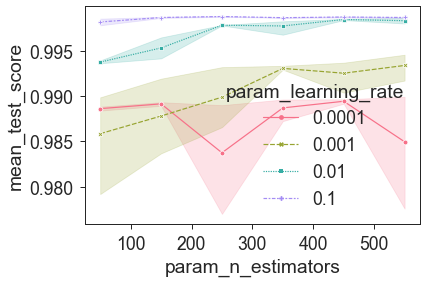

In [272]:
sns.lineplot(
    data=df_random_search_results, x='param_n_estimators', y='mean_test_score', hue='param_learning_rate',
    palette=palette, style="param_learning_rate", markers=True
);

### mean_test_score vs param_num_leaves vs param_learning_rate

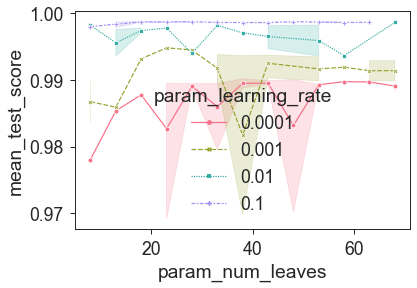

In [273]:
sns.lineplot(
    data=df_random_search_results, x='param_num_leaves', y='mean_test_score', hue='param_learning_rate',
    palette=palette, style="param_learning_rate", markers=True
);

### mean_test_score vs param_max_depth vs param_learning_rate

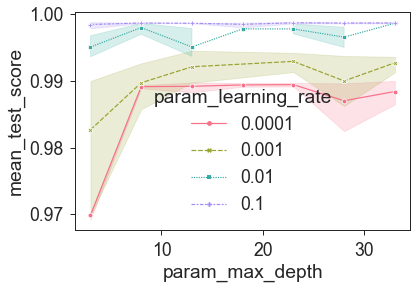

In [274]:
sns.lineplot(
    data=df_random_search_results, x='param_max_depth', y='mean_test_score', hue='param_learning_rate',
    palette=palette, style="param_learning_rate", markers=True
);

### For param_learning_rate = 0.1

#### mean_test_score vs param_max_depth vs param_num_leaves

In [290]:
# Defining palette
n_colors = df_random_search_results.loc[
    df_random_search_results['param_learning_rate']==best_rscv['learning_rate'], 'param_num_leaves'
].nunique()
palette = sns.color_palette("husl", n_colors)

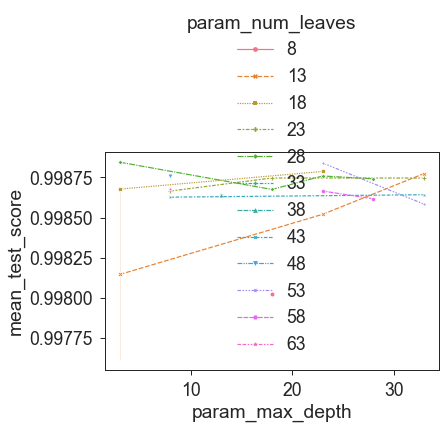

In [291]:
sns.lineplot(
    data=df_random_search_results.loc[df_random_search_results['param_learning_rate']==best_rscv['learning_rate'], :],
    x='param_max_depth', y='mean_test_score', hue='param_num_leaves',
    palette=palette, style="param_num_leaves", markers=True
);

#### mean_test_score vs param_max_depth vs param_n_estimators

In [292]:
# Defining palette
n_colors = df_random_search_results['param_n_estimators'].nunique()
palette = sns.color_palette("husl", n_colors)

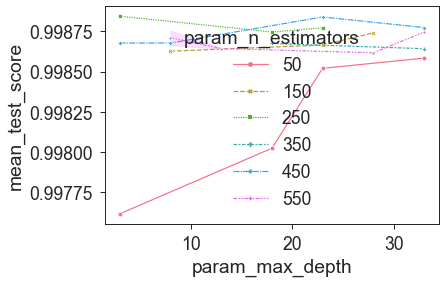

In [293]:
sns.lineplot(
    data=df_random_search_results.loc[df_random_search_results['param_learning_rate']==best_rscv['learning_rate'], :],
    x='param_max_depth', y='mean_test_score', hue='param_n_estimators',
    palette=palette, style="param_n_estimators", markers=True
);

## Grid search

In [332]:
dct_params = dict(
    max_depth=np.arange(max(best_rscv['max_depth']-2, 2), best_rscv['max_depth']+4, 1),
    num_leaves=np.arange(best_rscv['num_leaves']-2, best_rscv['num_leaves']+4, 1),
    n_estimators = np.arange(best_rscv['n_estimators']-50, best_rscv['n_estimators']+50, 25).tolist(),
    learning_rate=np.arange(
        best_rscv['learning_rate']*.5, best_rscv['learning_rate']*1.5,
        best_rscv['learning_rate'] / 4
    )
)

dct_params

{'max_depth': array([2, 3, 4, 5, 6]),
 'num_leaves': array([26, 27, 28, 29, 30, 31]),
 'n_estimators': [200, 225, 250, 275],
 'learning_rate': array([0.05 , 0.075, 0.1  , 0.125, 0.15 ])}

In [333]:
classifier_lgbm = LGBMClassifier(
    random_state=RANDOM_STATE, n_jobs=-1, silent='warn', objective='binary', importance_type='gain',
)

gscv = GridSearchCV(
    classifier_lgbm, dct_params, error_score='raise',
    return_train_score=True, scoring='roc_auc', cv=10, n_jobs=-1
)

grid_search = gscv.fit(X_train_exp_02, y_train_exp_02)
best_gscv = grid_search.best_params_
best_gscv

{'learning_rate': 0.07500000000000001,
 'max_depth': 4,
 'n_estimators': 275,
 'num_leaves': 26}

In [334]:
df_grid_search_results = pd.DataFrame.from_dict(gscv.cv_results_, orient='columns')[
    ['rank_test_score', 'param_num_leaves', 'param_n_estimators', 'param_max_depth', 'param_learning_rate',
     'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'mean_test_score', 'std_test_score',
     'mean_train_score', 'std_train_score']
]

# Rounding df
df_grid_search_results['param_learning_rate'] = df_grid_search_results['param_learning_rate'].apply(round_4)

df_grid_search_results.sort_values(by=['rank_test_score'], ascending=True)[:10]

,rank_test_score,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,mean_train_score,std_train_score
188,1,28,275,4,0.07500,0.42964,0.02153,0.01801,0.00683,0.99889,0.00079,1.00000,0.00000
189,1,29,275,4,0.07500,0.41164,0.01001,0.01550,0.00176,0.99889,0.00079,1.00000,0.00000
187,1,27,275,4,0.07500,0.41898,0.01500,0.01556,0.00156,0.99889,0.00079,1.00000,0.00000
186,1,26,275,4,0.07500,0.40873,0.01350,0.01605,0.00218,0.99889,0.00079,1.00000,0.00000
190,1,30,275,4,0.07500,0.45614,0.04058,0.01510,0.00102,0.99889,0.00079,1.00000,0.00000
191,1,31,275,4,0.07500,0.42579,0.02467,0.01616,0.00137,0.99889,0.00079,1.00000,0.00000
173,7,31,200,4,0.07500,0.35112,0.04692,0.01512,0.00219,0.99888,0.00073,1.00000,0.00000
171,7,29,200,4,0.07500,0.36025,0.02962,0.01315,0.00123,0.99888,0.00073,1.00000,0.00000
170,7,28,200,4,0.07500,0.36480,0.02830,0.01480,0.00483,0.99888,0.00073,1.00000,0.00000
169,7,27,200,4,0.07500,0.35398,0.02475,0.01384,0.00193,0.99888,0.00073,1.00000,0.00000


### mean_test_score vs n_estimators vs param_learning_rate

In [297]:
# Defining palette
n_colors = df_grid_search_results['param_learning_rate'].nunique()
palette = sns.color_palette("husl", n_colors)

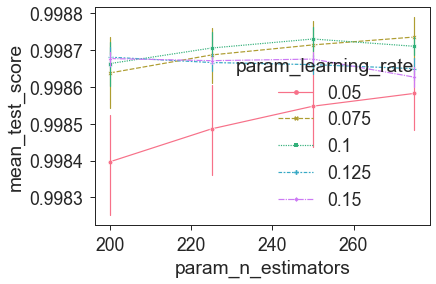

In [298]:
sns.lineplot(
    data=df_grid_search_results, x='param_n_estimators', y='mean_test_score', hue='param_learning_rate',
    palette=palette, style="param_learning_rate", markers=True, ci=90, err_style='bars'
);

### mean_test_score vs param_num_leaves vs param_learning_rate

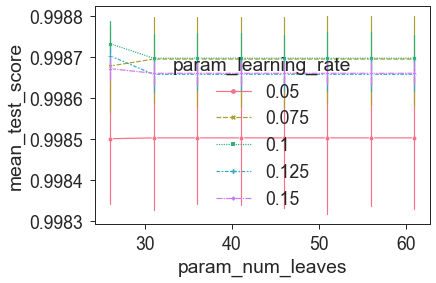

In [299]:
sns.lineplot(
    data=df_grid_search_results, x='param_num_leaves', y='mean_test_score', hue='param_learning_rate',
    palette=palette, style="param_learning_rate", markers=True, ci=90, err_style='bars'
);

### mean_test_score vs param_max_depth vs param_learning_rate

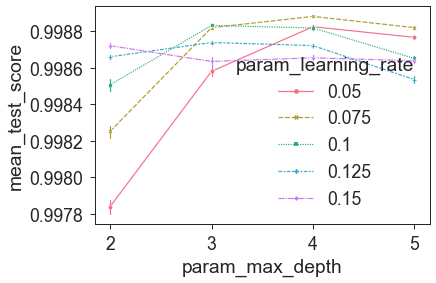

In [300]:
sns.lineplot(
    data=df_grid_search_results, x='param_max_depth', y='mean_test_score', hue='param_learning_rate',
    palette=palette, style="param_learning_rate", markers=True, ci=90, err_style='bars'
);

### For param_learning_rate = 0.0750

#### mean_test_score vs param_max_depth vs param_num_leaves

In [301]:
best_learning_rate = round(best_gscv['learning_rate'], 4)
best_learning_rate

0.075

In [302]:
# Defining palette
n_colors = df_grid_search_results['param_num_leaves'].nunique()
palette = sns.color_palette("husl", n_colors)
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8087954113106306, 0.5634700050056693, 0.19502642696727285),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.19783576093349015, 0.6955516966063037, 0.3995301037444499),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.22335772267769388, 0.6565792317435265, 0.8171355503265633),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.9603888539940703, 0.3814317878772117, 0.8683117650835491)]

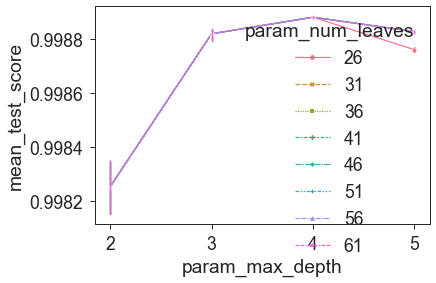

In [303]:
sns.lineplot(
    data=df_grid_search_results.loc[df_grid_search_results['param_learning_rate']==best_learning_rate, :],
    x='param_max_depth', y='mean_test_score', hue='param_num_leaves', ci=90, err_style='bars',
    palette=palette, style="param_num_leaves", markers=True
);

#### mean_test_score vs param_max_depth vs param_n_estimators

In [304]:
# Defining palette
n_colors = df_grid_search_results['param_n_estimators'].nunique()
palette = sns.color_palette("husl", n_colors)
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727)]

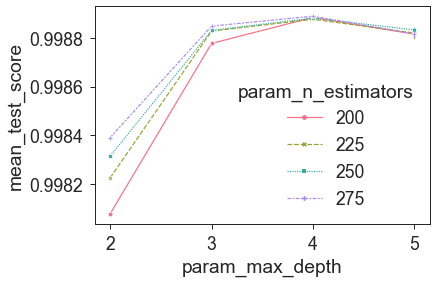

In [305]:
sns.lineplot(
    data=df_grid_search_results.loc[df_grid_search_results['param_learning_rate']==best_learning_rate, :],
    x='param_max_depth', y='mean_test_score', hue='param_n_estimators', ci=90, err_style='bars',
    palette=palette, style="param_n_estimators", markers=True
);

## AUC vs n_estimators vs depth

- 10-fold cross validation

In [306]:
# X_exp_02 = pd.concat([X_train_exp_02, X_test_exp_02], axis=0)
# y_exp_02 = pd.concat([y_train_exp_02, y_test_exp_02], axis=0)

X_exp_02 = X_train_exp_02.copy()
y_exp_02 = y_train_exp_02.copy()

In [307]:
best_params = dict(
    random_state=RANDOM_STATE, n_jobs=-1, silent='warn', objective='binary', importance_type='split',
    learning_rate=best_gscv['learning_rate'], num_leaves=best_gscv['num_leaves']
)

best_params

{'random_state': 42,
 'n_jobs': -1,
 'silent': 'warn',
 'objective': 'binary',
 'importance_type': 'split',
 'learning_rate': 0.07500000000000001,
 'num_leaves': 26}

In [336]:
scoring='roc_auc'
dct_results = {}

for n_estimator in np.arange(75, 450, 25).tolist():
# for n_estimator in [100]:
    for depth in [3, 4, 5, 13, 23, 33]:
        classifier_lgbm = LGBMClassifier(
            **best_params, n_estimators=n_estimator, max_depth=depth
        )

        cross = cross_validate(
            estimator=classifier_lgbm, X=X_exp_02, y=y_exp_02, scoring=scoring, cv=10,
            n_jobs=-1, verbose=0, return_train_score=True, 
        )

        dct_results[str(n_estimator)+'_'+str(depth)] = {
            'n_estimator': n_estimator,
            'depth': depth,
            'test_score_mean': cross['test_score'].mean(),
            'test_score_std': cross['test_score'].std(),
            'train_score_mean': cross['train_score'].mean(),
            'train_score_std': cross['train_score'].std()
        }

df_results_auc = pd.DataFrame.from_dict(dct_results, orient='index')

df_results_auc.sort_values(by='test_score_mean', ascending=False).head()

,n_estimator,depth,test_score_mean,test_score_std,train_score_mean,train_score_std
275_4,275,4,0.99889,0.00079,1.00000,0.00000
200_4,200,4,0.99888,0.00073,1.00000,0.00000
250_4,250,4,0.99888,0.00076,1.00000,0.00000
225_4,225,4,0.99888,0.00075,1.00000,0.00000
300_4,300,4,0.99885,0.00080,1.00000,0.00000


In [337]:
df_results_auc

,n_estimator,depth,test_score_mean,test_score_std,train_score_mean,train_score_std
75_3,75,3,0.99788,0.00117,0.99911,0.00004
75_4,75,4,0.99838,0.00084,0.99965,0.00005
75_5,75,5,0.99835,0.00090,0.99988,0.00003
75_13,75,13,0.99859,0.00067,1.00000,0.00000
75_23,75,23,0.99862,0.00066,1.00000,0.00000
...,...,...,...,...,...,...
425_4,425,4,0.99877,0.00095,1.00000,0.00000
425_5,425,5,0.99863,0.00101,1.00000,0.00000
425_13,425,13,0.99878,0.00069,1.00000,0.00000
425_23,425,23,0.99872,0.00072,1.00000,0.00000


In [338]:
# Defining palette
n_colors = df_results_auc['depth'].nunique()
palette = sns.color_palette("husl", n_colors)
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225)]

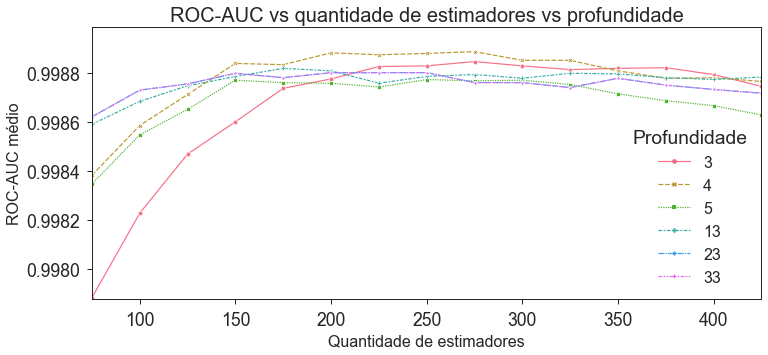

In [339]:
plt.figure(figsize=(12, 5))

ax = sns.lineplot(
    data=df_results_auc, x='n_estimator', y='test_score_mean', hue='depth', style='depth',
    palette=palette, markers=True
)

ax.set_title("ROC-AUC vs quantidade de estimadores vs profundidade", fontsize=20)
ax.set_xlabel("Quantidade de estimadores", fontsize=16)
ax.set_ylabel("ROC-AUC médio", fontsize=16)

sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1))
plt.legend(title='Profundidade', fontsize=16)
ax.set_xlim(df_results_auc['n_estimator'].min(), df_results_auc['n_estimator'].max())
ax.set_ylim(df_results_auc['test_score_mean'].min()*.999995, df_results_auc['test_score_mean'].max()*1.0001);

## Log loss vs iterations vs train-test

In [312]:
lst_iterations = np.arange(1, 326, 4).tolist()
# lst_iterations[0] = 1
# lst_iterations

In [313]:
scoring='neg_log_loss'
dct_results = {}
depth = best_gscv['max_depth']
n_estimator = best_gscv['n_estimators']


for n_estimator in lst_iterations:
    classifier_lgbm = LGBMClassifier(
            **best_params, n_estimators=n_estimator, max_depth=depth
        )
    
    cross = cross_validate(
        estimator=classifier_lgbm, X=X_exp_02, y=y_exp_02, scoring=scoring, cv=10,
        n_jobs=-1, verbose=0, return_train_score=True, 
    )

    dct_results[str(n_estimator)+'_'+str(depth)] = {
        'n_estimator': n_estimator,
        'test_score_mean': abs(cross['test_score'].mean()),
        'test_score_std': cross['test_score'].std(),
        'train_score_mean': abs(cross['train_score'].mean()),
        'train_score_std': cross['train_score'].std(),
    }

df_results_logloss = pd.DataFrame.from_dict(dct_results, orient='index')
df_results_logloss.columns = [
    'Estimadores', 'Média no conjunto de teste', 'test_score_std', 'Média no conjunto treino', 'train_score_std'
]
df_results_logloss.head()

,Estimadores,Média no conjunto de teste,test_score_std,Média no conjunto treino,train_score_std
1_4,1,0.63074,0.00095,0.62989,0.00030
5_4,5,0.45804,0.00417,0.45382,0.00101
9_4,9,0.34869,0.00558,0.34294,0.00103
13_4,13,0.27426,0.00612,0.26690,0.00080
17_4,17,0.22118,0.00673,0.21292,0.00111


In [314]:
df_results_logloss.columns

Index(['Estimadores', 'Média no conjunto de teste', 'test_score_std',
       'Média no conjunto treino', 'train_score_std'],
      dtype='object')

In [315]:
df_results_logloss_melted = df_results_logloss[
    ['Estimadores', 'Média no conjunto de teste', 'Média no conjunto treino']
].melt(['Estimadores'], var_name='scores', value_name='mean')

df_results_logloss_melted.sample(3, random_state=RANDOM_STATE)

,Estimadores,scores,mean
135,213,Média no conjunto treino,0.00718
115,133,Média no conjunto treino,0.01871
131,197,Média no conjunto treino,0.00866


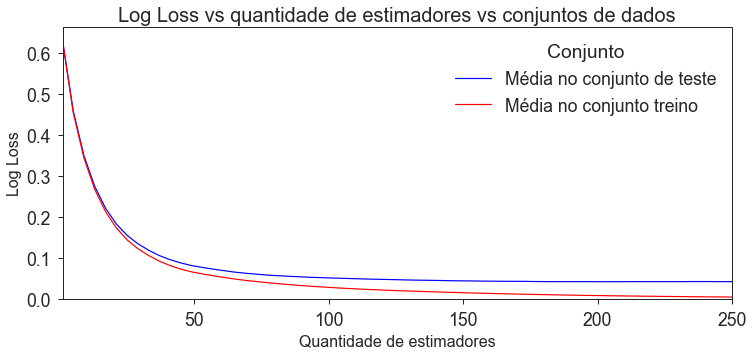

In [316]:
plt.figure(figsize=(12, 5))

ax = sns.lineplot(
    data=df_results_logloss_melted, x='Estimadores', y='mean', hue='scores', palette=['blue', 'red']
)

ax.set_title("Log Loss vs quantidade de estimadores vs conjuntos de dados", fontsize=20)
ax.set_xlabel("Quantidade de estimadores", fontsize=16)
ax.set_ylabel("Log Loss", fontsize=16)
plt.legend(title='Conjunto', fontsize=16)

sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1))
ax.set_xlim(min(lst_iterations), 250)
ax.set_ylim(0, df_results_logloss_melted['mean'].max()*1.05);

In [317]:
df_results_logloss.sort_values(by=['Média no conjunto de teste'], ascending=False)

,Estimadores,Média no conjunto de teste,test_score_std,Média no conjunto treino,train_score_std
1_4,1,0.63074,0.00095,0.62989,0.00030
5_4,5,0.45804,0.00417,0.45382,0.00101
9_4,9,0.34869,0.00558,0.34294,0.00103
13_4,13,0.27426,0.00612,0.26690,0.00080
17_4,17,0.22118,0.00673,0.21292,0.00111
...,...,...,...,...,...
269_4,269,0.04226,0.01689,0.00394,0.00027
277_4,277,0.04226,0.01722,0.00364,0.00027
205_4,205,0.04219,0.01382,0.00786,0.00038
209_4,209,0.04217,0.01397,0.00751,0.00033


## Feature importance

In [342]:
classifier_lgbm = LGBMClassifier(
    random_state=RANDOM_STATE, n_jobs=-1, silent='warn', objective='binary', importance_type='gain', **best_gscv
)

classifier_lgbm.fit(X_exp_02, y_exp_02)

LGBMClassifier(importance_type='gain', learning_rate=0.07500000000000001,
               max_depth=4, n_estimators=275, num_leaves=26, objective='binary',
               random_state=42)

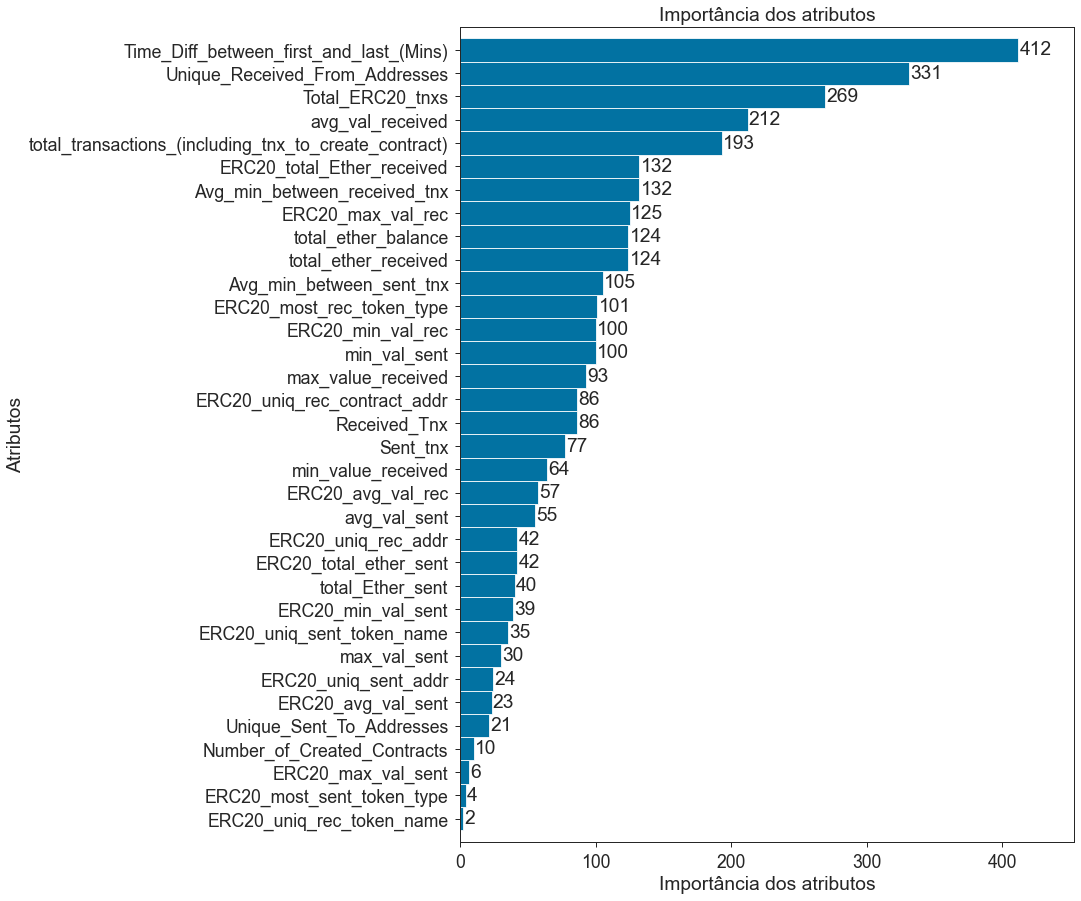

In [343]:
plot_importance(
    classifier_lgbm, height=1, xlim=None, ylim=None,
    title='Importância dos atributos', xlabel='Importância dos atributos', ylabel='Atributos', importance_type='split',
    max_num_features=None, ignore_zero=True, figsize=(11, 15), dpi=None, grid=False, precision=0
);

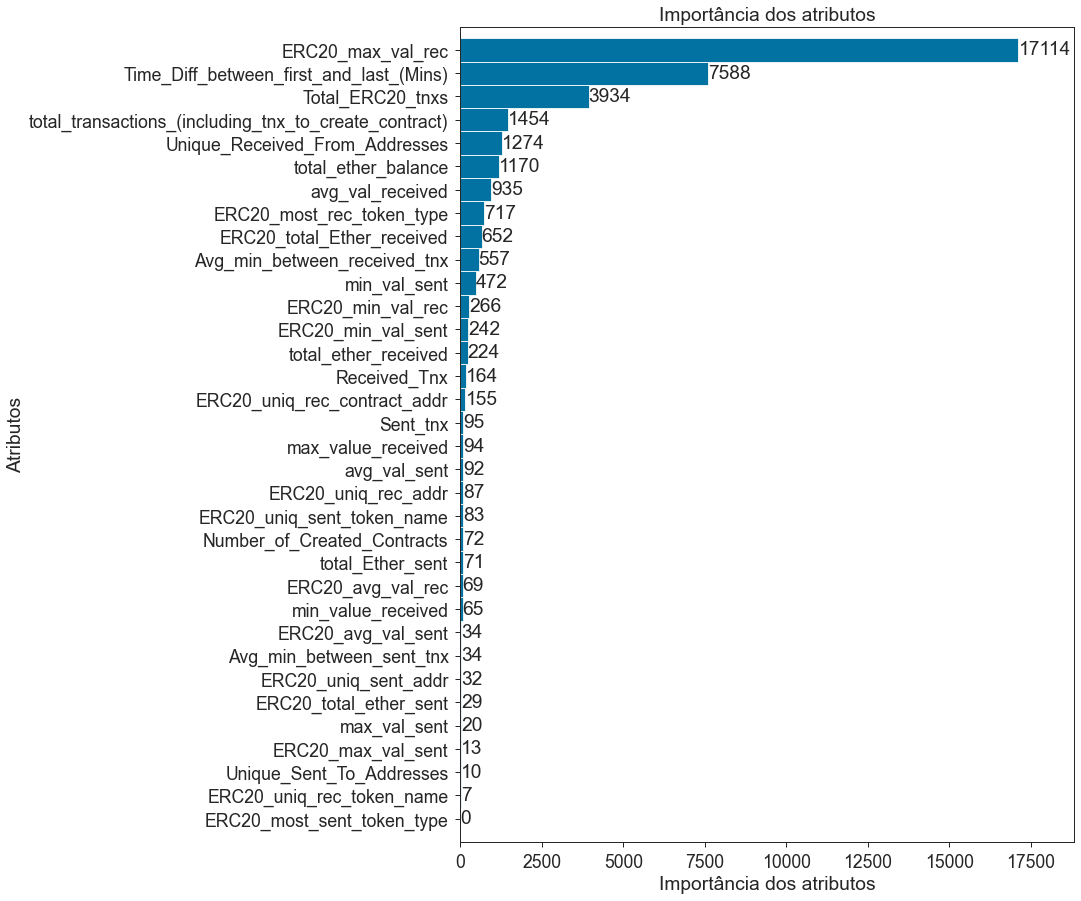

In [320]:
plot_importance(
    classifier_lgbm, height=1, xlim=None, ylim=None,
    title='Importância dos atributos', xlabel='Importância dos atributos', ylabel='Atributos', importance_type='gain',
    max_num_features=None, ignore_zero=True, figsize=(11, 15), dpi=None, grid=False, precision=0
);

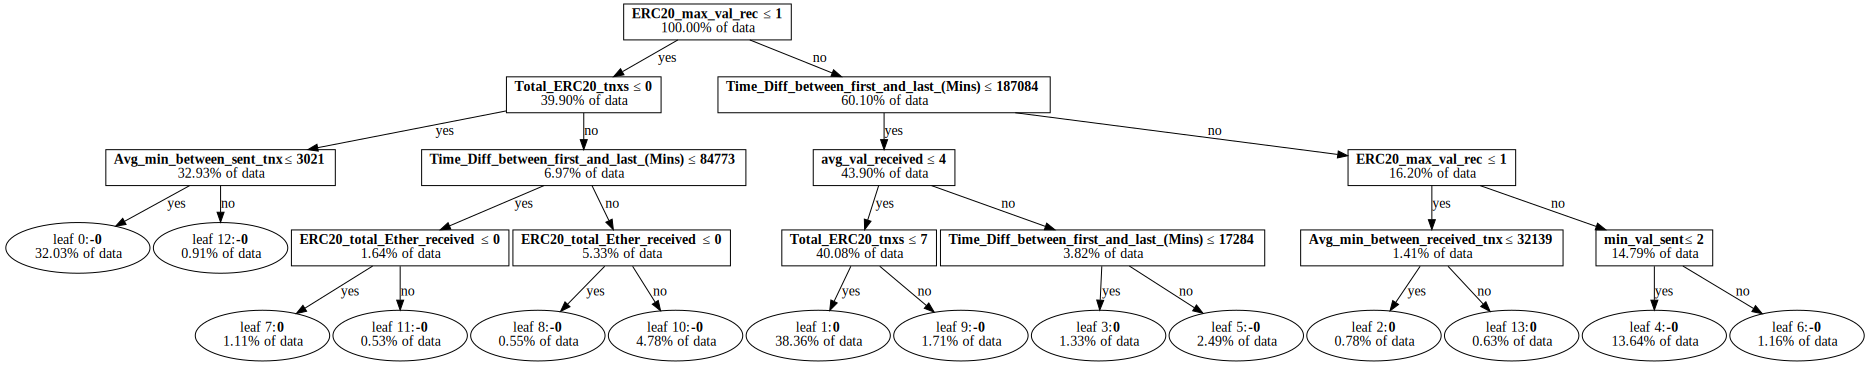

In [203]:
create_tree_digraph(classifier_lgbm, tree_index=0, show_info=['data_percentage'], precision=0, orientation='vertical')
# .render(filename='g1.png')
# .view()

## Feature selection

In [321]:
selector = RFECV(classifier_lgbm, step=1, cv=10, scoring='roc_auc', n_jobs=-1)
selector.fit(X_exp_02, y_exp_02)

RFECV(cv=10,
      estimator=LGBMClassifier(importance_type='gain',
                               learning_rate=0.07500000000000001, max_depth=4,
                               n_estimators=275, num_leaves=26,
                               objective='binary', random_state=42),
      n_jobs=-1, scoring='roc_auc')

In [322]:
selector.n_features_

31

In [323]:
len(selector.ranking_)

36

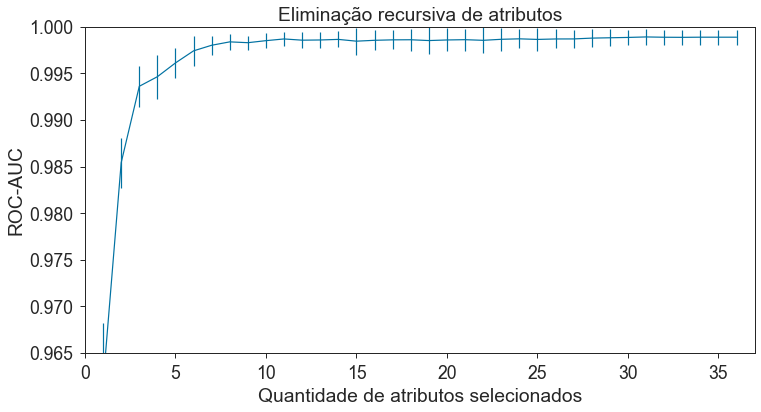

In [324]:
n_scores = len(selector.cv_results_["mean_test_score"])

plt.figure(figsize=(12, 6))
plt.xlabel("Quantidade de atributos selecionados")
plt.ylabel("ROC-AUC")
plt.ylim(0.965, 1)
plt.xlim(0, 37)
plt.errorbar(
    range(1, n_scores + 1),
    selector.cv_results_["mean_test_score"],
    yerr=selector.cv_results_["std_test_score"],
)
plt.title("Eliminação recursiva de atributos")
plt.show()